In [1]:
%matplotlib inline

import json
import ast

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from pathlib import Path
from typing import List

from jass.logs.game_log_entry import GameLogEntry
from jass.game.game_state import GameState
from jass.game.game_state_util import state_from_complete_game, observation_from_state
from jass.game.game_util import convert_int_encoded_cards_to_str_encoded, convert_one_hot_encoded_cards_to_str_encoded_list, get_cards_encoded

from jass.game.rule_schieber import RuleSchieber

game_rule = RuleSchieber()
path_to_data = Path('../data')

In [2]:
cards = [
# Diamonds
'DA','DK','DQ','DJ','D10','D9','D8','D7','D6',
# Hearts
'HA','HK','HQ','HJ','H10','H9','H8','H7','H6',
# Spades
'SA','SK','SQ','SJ','S10','S9','S8','S7','S6',
# Clubs
'CA','CK','CQ','CJ','C10','C9','C8','C7','C6'
]

# Card Selection with Deep Neural Network (Keras)

Data originally from Swisslos Jass Platform is available
- under Data/games on Illias,
- and on the /exchange/dl4g/data/games folder on the GPU cluster
- Each data file contains 100000 games
- Each line is a complete game in json format that can be read by


GameLogEntry.from_json() to get an entry
- An entry consists of:
- The game (as GameState for a complete game)
- The date
- The player ids on the server, id=0 for anonymous play

## Data Analysis

Here is an example GameEntry datastructure

In [3]:
GameLogEntry.from_json(
    {
        "game": {
            "version": "V0.2",
            "trump": 1,
            "dealer": 2,
            "currentPlayer": -1,
            "forehand": 0,
            "tricks": [
                {
                    "cards": ["HA", "H9", "H10", "D10"],
                    "points": 45,
                    "win": 0,
                    "first": 1,
                },
                {
                    "cards": ["CJ", "CA", "C7", "C10"],
                    "points": 23,
                    "win": 3,
                    "first": 0,
                },
                {
                    "cards": ["S6", "S10", "SQ", "S9"],
                    "points": 13,
                    "win": 1,
                    "first": 3,
                },
                {"cards": ["SA", "C6", "H7", "S7"], "points": 11, "win": 3, "first": 1},
                {"cards": ["SK", "SJ", "S8", "C8"], "points": 6, "win": 3, "first": 3},
                {"cards": ["D7", "DJ", "HQ", "DA"], "points": 16, "win": 1, "first": 3},
                {"cards": ["D9", "DK", "HK", "DQ"], "points": 11, "win": 3, "first": 1},
                {"cards": ["HJ", "C9", "H6", "D6"], "points": 20, "win": 3, "first": 3},
                {"cards": ["H8", "CQ", "D8", "CK"], "points": 12, "win": 3, "first": 3},
            ],
            "player": [{"hand": []}, {"hand": []}, {"hand": []}, {"hand": []}],
            "jassTyp": "SCHIEBER",
        },
        "date": "13.10.17 22:31:05",
        "player_ids": [58663, 21516, 41630, 70654],
    }
)

In order to load a file of games we need to iterate over the lines and convert them to GameLogEntry objects

In [4]:
# TODO: when model is defined and ready for training add all files to the training data

game_entries = []
with open(path_to_data / 'games/jass_game_0001.txt') as f:
    for line in f:
        game_entries.append(GameLogEntry.from_json(json.loads(line)))
    
game_entries = np.array(game_entries)
print("%d bytes" % (game_entries.size * game_entries.itemsize))


800000 bytes


### Specific GameState from Complete GameState

In order to retriev a specific GameState from a complete GameState we can use the `state_from_complete_game` function.

In [5]:
state_from_complete_game(game_entries[0].game, 5).to_json()

{'version': 'V0.2',
 'trump': 1,
 'dealer': 2,
 'currentPlayer': 3,
 'forehand': 0,
 'tricks': [{'cards': [np.str_('HA'),
    np.str_('H9'),
    np.str_('H10'),
    np.str_('D10')],
   'points': 45,
   'win': 0,
   'first': 1},
  {'cards': [np.str_('CJ')], 'first': 0}],
 'player': [{'hand': [np.str_('DA'),
    np.str_('DK'),
    np.str_('D6'),
    np.str_('S9'),
    np.str_('CK'),
    np.str_('C8'),
    np.str_('C6')]},
  {'hand': [np.str_('D9'),
    np.str_('D8'),
    np.str_('HQ'),
    np.str_('H6'),
    np.str_('SA'),
    np.str_('SQ'),
    np.str_('S8'),
    np.str_('C10')]},
  {'hand': [np.str_('DQ'),
    np.str_('DJ'),
    np.str_('SJ'),
    np.str_('S10'),
    np.str_('S7'),
    np.str_('CQ'),
    np.str_('C9'),
    np.str_('C7')]},
  {'hand': [np.str_('D7'),
    np.str_('HK'),
    np.str_('HJ'),
    np.str_('H8'),
    np.str_('H7'),
    np.str_('SK'),
    np.str_('S6'),
    np.str_('CA')]}],
 'jassTyp': 'SCHIEBER'}

## Analyse Player Stats

In [6]:
player_stats = pd.read_json(path_to_data / 'stat' / 'player_all_stat.json')
player_stats.head()

,id,mean,std,nr
0,0,78.433100,42.186764,1978858
1,6955,76.191936,41.780344,4241
2,54404,78.010880,41.985297,7445
3,74994,76.775460,41.428476,7669
4,56143,76.774029,41.546253,978


<Axes: ylabel='mean'>

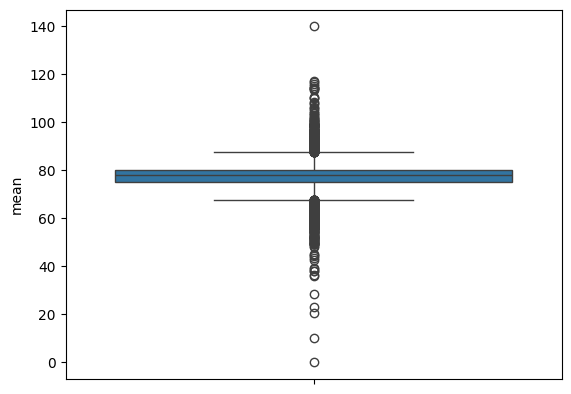

In [7]:
sns.boxplot(player_stats['mean']) 

In [8]:
player_stats = player_stats[player_stats['mean'] > player_stats['mean'].mean()]

In [9]:
player_stats = player_stats[player_stats['nr'] > 100]

<Axes: ylabel='mean'>

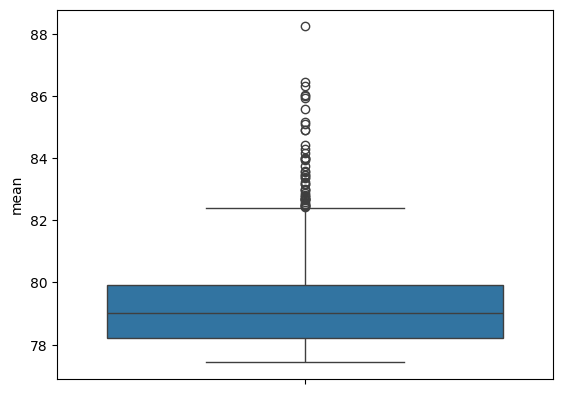

In [10]:
sns.boxplot(player_stats['mean']) 

In [11]:
# collect player ids and build dataset from their views
player_ids = player_stats['id'].to_numpy()

## Dataset Structure for Model Training

### Simple
Features: (2x36 = 72)
- cards played in current round (9x9 = 36)
- valid cards (9x9 = 36)

Target: (9x9 = 36 -> only select one! / or probability)
- choose one of the valid cards in own hand
- one-hot-encoding of all cards
- select only cards that are available
- select only cards that are valid

### More Useful Information
Features: (4x36 = 144)
- already played cards (9x9 = 36)
- cards played in current round (9x9 = 36)
- cards in hand (9x9 = 36)
- valid cards (9x9 = 36)

Target: (9x9 = 36 -> only select one! / or probability)
- choose one of the valid cards in own hand
- one-hot-encoding of all cards
- select only cards that are available
- select only cards that are valid

# Simple Card Play Model

Remove all GameLogs that do not have a user in the calculated userid list

In [12]:
good_games: List[GameLogEntry] = [game for game in game_entries if any(player in player_ids for player in game.player_ids)]

len(good_games)

99884

In [13]:
data = pd.DataFrame({
    'trump': 'TPTP', 
    'played_cards': [[1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], 
    'valid_cards': [[1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], 
    'selected_card': [[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]})

data.head()

,trump,played_cards,valid_cards,selected_card
0,TPTP,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, ...","[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [14]:
# Print iterations progress
def printProgressBar(iteration, total, prefix = '', suffix = '', decimals = 1, length = 100, fill = '█', printEnd = "\r"):
    """
    Call in a loop to create terminal progress bar
    @params:
        iteration   - Required  : current iteration (Int)
        total       - Required  : total iterations (Int)
        prefix      - Optional  : prefix string (Str)
        suffix      - Optional  : suffix string (Str)
        decimals    - Optional  : positive number of decimals in percent complete (Int)
        length      - Optional  : character length of bar (Int)
        fill        - Optional  : bar fill character (Str)
        printEnd    - Optional  : end character (e.g. "\r", "\r\n") (Str)
    """
    percent = ("{0:." + str(decimals) + "f}").format(100 * (iteration / float(total)))
    filledLength = int(length * iteration // total)
    bar = fill * filledLength + '-' * (length - filledLength)
    print(f'\r{prefix} |{bar}| {percent}% {suffix}', end = printEnd)
    # Print New Line on Complete
    if iteration == total: 
        print()
        
def collect_data_from_game_logs():
    max_iterations = len(good_games)
    printProgressBar(0, max_iterations, prefix = 'Progress:', suffix = 'Complete', length = 50)
    
    data_rows = []  # Store rows here and add them to DataFrame in bulk at the end
    
    for idx, game_log in enumerate(good_games):
        if idx % 10 == 0:  # Update the progress bar less frequently
            printProgressBar(idx + 1, max_iterations, prefix='Progress:', suffix='Complete', length=50)
                
        for player_index, player in enumerate(game_log.player_ids):
            if player not in player_ids:
                continue
                    
            for cards_played in range(36):  # Iterate through all possible states
                state = state_from_complete_game(game_log.game, cards_played)
                if state.player != player_index:  # Check if it's the specified player's turn
                    continue
                    
                played_cards = []

                # Iterate through the tricks to collect played cards
                for trick in state.tricks:
                    for card in trick:
                        if card != -1:  # Only consider valid cards
                            played_cards.append(card)

                # Convert to string representation if needed
                played_cards_encoded = get_cards_encoded(played_cards)
                
                valid_cards_encoded = game_rule.get_valid_cards_from_state(state)
                
                # evaluate the played card by the player from the next following state
                selected_card = -1
                next_state = None
                if cards_played == 35:
                    next_state = game_log.game
                    selected_card = next_state.tricks[-1, -1]
                else:
                    next_state = state_from_complete_game(game_log.game, cards_played + 1)
                    next_state_trick = [card for card in next_state.current_trick if card != -1]
                    if len(next_state_trick) != 0:
                        selected_card = next_state_trick[-1]
                    else:
                        next_state_trick = next_state.tricks[next_state.nr_tricks - 1, :]
                        selected_card = next_state_trick[-1]
                    
                selected_card_encoded = get_cards_encoded([selected_card])
                
                # Add the game state as a row
                data_rows.append([
                    game_log.game.trump, played_cards_encoded, valid_cards_encoded, selected_card_encoded
                ])
                
        if idx % 10000 == 0:
            global data
            data = pd.concat([data, pd.DataFrame(data_rows, columns=['trump', 'played_cards', 'valid_cards', 'selected_card'])], ignore_index=True)
            data_rows = []
            assert len(data_rows) == 0
                
collect_data_from_game_logs()

### Remove the template entry

In [15]:
data.drop(data[data['trump'] == 'TPTP'].index, inplace=True)
data.head()

,trump,played_cards,valid_cards,selected_card
1,1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ..."
2,1,"[0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, ...","[1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,1,"[0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,1,"[0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, ...","[1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
5,1,"[0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, ...","[1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


### Analyse the generated Data

In [17]:
data.count()

trump            2734551
played_cards     2734551
valid_cards      2734551
selected_card    2734551
dtype: int64

In [18]:
data.trump = data.trump.astype('category')
data.trump = data.trump.cat.rename_categories({0: 'DIAMONDS', 1: 'HEARTS', 2: 'SPADES', 3:'CLUBS',
                                  4: 'OBE_ABE', 5: 'UNE_UFE', 6: 'PUSH', 10: 'PUSH'})

In [19]:
data.trump.unique()

['HEARTS', 'CLUBS', 'SPADES', 'UNE_UFE', 'OBE_ABE', 'DIAMONDS']
Categories (6, object): ['DIAMONDS', 'HEARTS', 'SPADES', 'CLUBS', 'OBE_ABE', 'UNE_UFE']

## Split one-hod-encoded columns into multiple

### Played Cards

In [20]:
column_names = ['played_cards_' + card for card in cards]

data[column_names] = pd.DataFrame(data['played_cards'].to_list(), index=data.index)
data.drop('played_cards', axis=1, inplace=True)

### Valid Cards

In [21]:
column_names = ['valid_cards_' + card for card in cards]

data[column_names] = pd.DataFrame(data['valid_cards'].to_list(), index=data.index)
data.drop('valid_cards', axis=1, inplace=True)

### Selected Card

In [22]:
column_names = ['selected_card_' + card for card in cards]

data[column_names] = pd.DataFrame(data['selected_card'].to_list(), index=data.index)
data.drop('selected_card', axis=1, inplace=True)

/var/folders/1j/wtq97vbs2pl0w4tb09kq4m1r0000gn/T/ipykernel_50199/4280139768.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[column_names] = pd.DataFrame(data['selected_card'].to_list(), index=data.index)
/var/folders/1j/wtq97vbs2pl0w4tb09kq4m1r0000gn/T/ipykernel_50199/4280139768.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[column_names] = pd.DataFrame(data['selected_card'].to_list(), index=data.index)
/var/folders/1j/wtq97vbs2pl0w4tb09kq4m1r0000gn/T/ipykernel_50199/4280139768.py:3: PerformanceWarning: DataFr

In [23]:
data.head()

,trump,played_cards_DA,played_cards_DK,played_cards_DQ,played_cards_DJ,played_cards_D10,played_cards_D9,played_cards_D8,played_cards_D7,played_cards_D6,...,selected_card_S6,selected_card_CA,selected_card_CK,selected_card_CQ,selected_card_CJ,selected_card_C10,selected_card_C9,selected_card_C8,selected_card_C7,selected_card_C6
1,HEARTS,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,HEARTS,0,0,0,0,1,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
3,HEARTS,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,HEARTS,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
5,HEARTS,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [24]:
data.columns.to_list()

['trump',
 'played_cards_DA',
 'played_cards_DK',
 'played_cards_DQ',
 'played_cards_DJ',
 'played_cards_D10',
 'played_cards_D9',
 'played_cards_D8',
 'played_cards_D7',
 'played_cards_D6',
 'played_cards_HA',
 'played_cards_HK',
 'played_cards_HQ',
 'played_cards_HJ',
 'played_cards_H10',
 'played_cards_H9',
 'played_cards_H8',
 'played_cards_H7',
 'played_cards_H6',
 'played_cards_SA',
 'played_cards_SK',
 'played_cards_SQ',
 'played_cards_SJ',
 'played_cards_S10',
 'played_cards_S9',
 'played_cards_S8',
 'played_cards_S7',
 'played_cards_S6',
 'played_cards_CA',
 'played_cards_CK',
 'played_cards_CQ',
 'played_cards_CJ',
 'played_cards_C10',
 'played_cards_C9',
 'played_cards_C8',
 'played_cards_C7',
 'played_cards_C6',
 'valid_cards_DA',
 'valid_cards_DK',
 'valid_cards_DQ',
 'valid_cards_DJ',
 'valid_cards_D10',
 'valid_cards_D9',
 'valid_cards_D8',
 'valid_cards_D7',
 'valid_cards_D6',
 'valid_cards_HA',
 'valid_cards_HK',
 'valid_cards_HQ',
 'valid_cards_HJ',
 'valid_cards_H10'

## Save the dataset

In [25]:
data.to_csv(path_to_data / 'card_prediction' / 'card_prediction_0002.csv', index=False)